In [1]:
import os
import cv2
import glob
import shutil
from tqdm import tqdm
import albumentations as A
import subprocess
import numpy as np
import yaml
import torch
from torch.utils.data import Dataset, DataLoader
import random
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Markdown
import time

def OK():
    print("✅ OK")

In [2]:
# Limpa diretório YOLOv5 se existir
if os.path.exists('/kaggle/working/yolov5/'):
    shutil.rmtree('/kaggle/working/yolov5/')

OK()

✅ OK


In [3]:
# ---------- CONFIGURAÇÕES ----------
# Paths do dataset original
BASE_PATH = "/kaggle/input/smoke-fire-detection-yolo/data"
TRAIN_IMG = os.path.join(BASE_PATH, "train/images")
TRAIN_LBL = os.path.join(BASE_PATH, "train/labels")
VAL_IMG   = os.path.join(BASE_PATH, "val/images")
VAL_LBL   = os.path.join(BASE_PATH, "val/labels")

# Verificação se os diretórios existem
for path in [TRAIN_IMG, TRAIN_LBL, VAL_IMG, VAL_LBL]:
    if not os.path.exists(path):
        print(f" Diretório não encontrado: {path}")
    else:
        print(f"Diretório encontrado: {path}")

# Classes YOLO
CLASSES = ["Smoke", "Fire"]

# YOLOv5 config
YOLO_DIR = "/kaggle/working/yolov5"
DATASET_DIR = "/kaggle/working/dataset"
YAML_CONF = os.path.join(YOLO_DIR, "data/custom_dataset.yaml")

# Hiperparâmetros de treinamento
IMG_SIZE = 640
BATCH = 16
EPOCHS = 50
MODEL_CFG = "yolov5s.yaml"
HYP_FILE = os.path.join(YOLO_DIR, "data/hyps/hyp.scratch-low.yaml")

OK()

Diretório encontrado: /kaggle/input/smoke-fire-detection-yolo/data/train/images
Diretório encontrado: /kaggle/input/smoke-fire-detection-yolo/data/train/labels
Diretório encontrado: /kaggle/input/smoke-fire-detection-yolo/data/val/images
Diretório encontrado: /kaggle/input/smoke-fire-detection-yolo/data/val/labels
✅ OK


In [4]:
class YOLODatasetOnTheFly(Dataset):
    def __init__(self, img_dir, label_dir, img_size=640, augment=True):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.img_size = img_size
        self.augment = augment

        # Lista todas as imagens
        self.img_files = glob.glob(os.path.join(img_dir, "*.jpg"))
        self.label_files = [os.path.join(label_dir, os.path.splitext(os.path.basename(f))[0] + ".txt") 
                           for f in self.img_files]

        # Pipeline de augmentação ON-THE-FLY
        self.transform = A.Compose([
            A.OneOf([
                A.HorizontalFlip(p=1.0),
                A.RandomRotate90(p=1.0),
                A.Rotate(limit=45, p=1.0),
                A.NoOp()
            ], p=0.8),
            A.OneOf([
                A.RandomBrightnessContrast(p=1.0),
                A.HueSaturationValue(p=1.0),
                A.RandomGamma(p=1.0),
                A.RGBShift(p=1.0),
                A.NoOp()
            ], p=0.7),
            A.Resize(img_size, img_size, p=1.0)
        ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

        self.augmentation_log = []

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        label_path = self.label_files[idx]

        # Carrega imagem
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Carrega labels
        bboxes = []
        class_labels = []

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    if line.strip():
                        cls, x, y, w, h = map(float, line.strip().split())
                        bboxes.append([x, y, w, h])
                        class_labels.append(int(cls))

        # Aplica augmentação ON-THE-FLY apenas se augment=True
        if self.augment and len(bboxes) > 0:
            try:
                transform_applied = self._get_transform_name()
                self.augmentation_log.append({
                    'image': os.path.basename(img_path),
                    'transform': transform_applied,
                    'timestamp': time.time()
                })

                augmented = self.transform(image=image, bboxes=bboxes, class_labels=class_labels)
                image = augmented['image']
                bboxes = augmented['bboxes']
                class_labels = augmented['class_labels']
            except Exception as e:
                print(f"Erro na augmentação: {e}")
                image = cv2.resize(image, (self.img_size, self.img_size))
        else:
            image = cv2.resize(image, (self.img_size, self.img_size))

        return image, bboxes, class_labels

    def _get_transform_name(self):
        transforms = ['HorizontalFlip', 'RandomRotate90', 'Rotate', 'Brightness/Contrast', 
                     'HueSaturation', 'Gamma', 'RGBShift', 'NoOp']
        return random.choice(transforms)

    def get_augmentation_stats(self):
        if not self.augmentation_log:
            return "Nenhuma augmentação registrada ainda"

        stats = {}
        for entry in self.augmentation_log:
            transform = entry['transform']
            stats[transform] = stats.get(transform, 0) + 1

        return stats

OK()

✅ OK


In [5]:
# ---------- PROVA DE AUGMENTATION ON-THE-FLY ----------
def demonstrate_onthefly_augmentation():
    print("PROVA DE DATA AUGMENTATION ON-THE-FLY")
    print("=" * 50)

    # Cria dataset de demonstração
    demo_dataset = YOLODatasetOnTheFly(TRAIN_IMG, TRAIN_LBL, augment=True)
    
    if len(demo_dataset) == 0:
        print("Nenhuma imagem encontrada no dataset")
        return

    # Pega a mesma imagem várias vezes para mostrar variações
    sample_idx = 0
    sample_images = []

    print(f"Aplicando augmentação na mesma imagem {5} vezes...")

    for i in range(5):
        img, bboxes, labels = demo_dataset[sample_idx]
        sample_images.append(img.copy())
        time.sleep(0.1)

    # Mostra as variações
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    for i, (ax, img) in enumerate(zip(axes, sample_images)):
        ax.imshow(img)
        ax.set_title(f"Variação {i+1}")
        ax.axis('off')

    plt.suptitle("Mesma imagem com augmentações diferentes a cada chamada", fontsize=16)
    plt.tight_layout()
    plt.show()

    # Mostra estatísticas
    stats = demo_dataset.get_augmentation_stats()
    print("\nEstatísticas de augmentações aplicadas:")
    for transform, count in stats.items():
        print(f"  {transform}: {count} vezes")

    print(f"\n✅ Total de augmentações registradas: {len(demo_dataset.augmentation_log)}")

OK()

✅ OK


In [6]:
print("Configurando ambiente para Data Augmentation On-the-Fly")

# Cria estrutura de diretórios
os.makedirs(DATASET_DIR, exist_ok=True)
for part in ["train", "val"]:
    for sub in ["images", "labels"]:
        dst = os.path.join(DATASET_DIR, part, sub)
        os.makedirs(dst, exist_ok=True)

OK()
for part, img_dir, lbl_dir in [("train", TRAIN_IMG, TRAIN_LBL), ("val", VAL_IMG, VAL_LBL)]:
    # Copia imagens
    img_files = glob.glob(os.path.join(img_dir, "*.jpg"))
    print(f"Copiando {len(img_files)} imagens para {part}")
    for img in img_files:
        shutil.copy(img, os.path.join(DATASET_DIR, part, "images"))
    
    # Copia labels
    lbl_files = glob.glob(os.path.join(lbl_dir, "*.txt"))
    print(f"Copiando {len(lbl_files)} labels para {part}")
    for lbl in lbl_files:
        shutil.copy(lbl, os.path.join(DATASET_DIR, part, "labels"))

OK()

Configurando ambiente para Data Augmentation On-the-Fly
✅ OK
Copiando 14122 imagens para train
Copiando 14122 labels para train
Copiando 3099 imagens para val
Copiando 3099 labels para val
✅ OK


PROVA DE DATA AUGMENTATION ON-THE-FLY
Aplicando augmentação na mesma imagem 5 vezes...


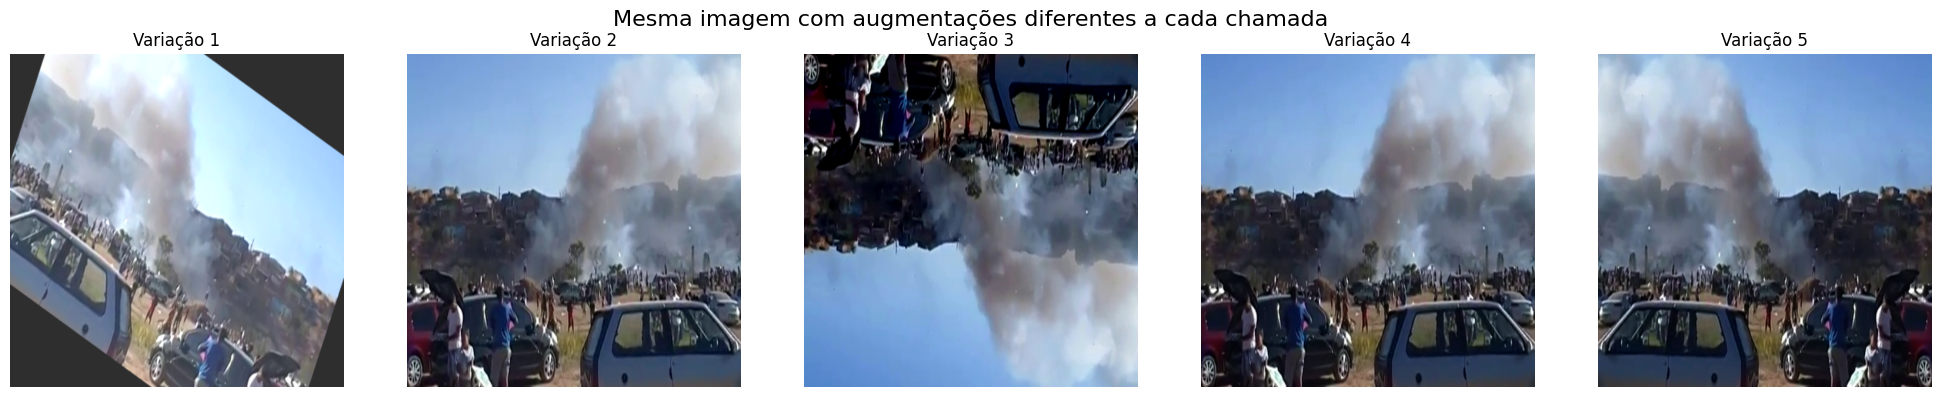


Estatísticas de augmentações aplicadas:
  Rotate: 1 vezes
  Brightness/Contrast: 1 vezes
  RGBShift: 2 vezes
  Gamma: 1 vezes

✅ Total de augmentações registradas: 5
✅ OK


Cloning into 'yolov5'...


YOLOv5 clonado
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
 

In [7]:
# ---------- DEMONSTRAÇÃO ON-THE-FLY ----------
demonstrate_onthefly_augmentation()

# ---------- CLONAR E CONFIGURAR YOLOv5 ----------
OK()

os.makedirs("/kaggle/working", exist_ok=True)
os.chdir("/kaggle/working")

if not os.path.isdir(YOLO_DIR):
    try:
        subprocess.run([
            "git", "clone", "--depth", "1",
            "https://github.com/ultralytics/yolov5.git",
            "yolov5"  # Nome relativo em vez de path absoluto
        ], check=True, cwd="/kaggle/working")
        print("YOLOv5 clonado")
    except subprocess.CalledProcessError as e:
        print(f"Erro ao clonar YOLOv5: {e}")
        # Método alternativo: usar os.system
        result = os.system("cd /kaggle/working && git clone --depth 1 https://github.com/ultralytics/yolov5.git yolov5")
        if result != 0:
            raise Exception("Não foi possível clonar o YOLOv5")

reqs = os.path.join(YOLO_DIR, "requirements.txt")
if os.path.isfile(reqs):
    try:
        subprocess.run(["pip", "install", "-r", reqs], check=True, cwd="/kaggle/working")
        print("Dependências instaladas")
    except subprocess.CalledProcessError as e:
        print(f"Erro ao instalar dependências: {e}")
        # Tenta instalar as dependências principais manualmente
        essential_packages = [
            "torch", "torchvision", "opencv-python", "pillow", 
            "matplotlib", "tqdm", "pyyaml", "seaborn"
        ]
        for package in essential_packages:
            try:
                subprocess.run(["pip", "install", package], check=True)
            except:
                print(f"Falha ao instalar {package}")
else:
    print("requirements.txt não encontrado")
    essential_packages = [
        "torch", "torchvision", "opencv-python", "pillow", 
        "matplotlib", "tqdm", "pyyaml", "seaborn"
    ]
    for package in essential_packages:
        try:
            subprocess.run(["pip", "install", package], check=True)
        except:
            print(f"Falha ao instalar {package}")

OK()

In [8]:
# ---------- PATCH PARA DATASET CUSTOMIZADO ----------
def patch_yolov5_dataset():
    
    custom_dataset_code = '''
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np
import os
import glob
import albumentations as A
import random
import time

class CustomYOLODataset(Dataset):
    def __init__(self, path, img_size=640, augment=False, hyp=None):
        self.path = path
        self.img_size = img_size
        self.augment = augment

        # Encontra todas as imagens
        self.img_files = glob.glob(os.path.join(path, "*.jpg"))
        if not self.img_files:
            print(f"❌ Nenhuma imagem encontrada em {path}")
            
        # Corrige o path dos labels
        self.label_files = []
        for img_file in self.img_files:
            label_file = img_file.replace('/images/', '/labels/').replace('.jpg', '.txt')
            self.label_files.append(label_file)

        print(f"Dataset: {len(self.img_files)} imagens encontradas em {path}")

        # Pipeline de augmentação
        if augment:
            self.transform = A.Compose([
                A.OneOf([
                    A.HorizontalFlip(p=1.0),
                    A.RandomRotate90(p=1.0),
                    A.Rotate(limit=30, p=1.0),
                    A.NoOp()
                ], p=0.8),
                A.OneOf([
                    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0),
                    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1.0),
                    A.RandomGamma(gamma_limit=(80, 120), p=1.0),
                    A.NoOp()
                ], p=0.7),
                A.Resize(img_size, img_size, p=1.0)
            ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))
        else:
            self.transform = A.Compose([
                A.Resize(img_size, img_size, p=1.0)
            ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, index):
        img_path = self.img_files[index]
        label_path = self.label_files[index]

        # Carrega imagem
        img = cv2.imread(img_path)
        if img is None:
            print(f"❌ Erro ao carregar imagem: {img_path}")
            return None, None, None, None
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h0, w0 = img.shape[:2]

        # Carrega labels
        labels = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    if line.strip():
                        try:
                            cls, x, y, w, h = map(float, line.strip().split())
                            labels.append([x, y, w, h, cls])
                        except ValueError:
                            continue

        # Converte para formato adequado para albumentations
        bboxes = []
        class_labels = []
        for label in labels:
            x, y, w, h, cls = label
            bboxes.append([x, y, w, h])
            class_labels.append(int(cls))

        # Aplica transformações
        if len(bboxes) > 0:
            try:
                augmented = self.transform(image=img, bboxes=bboxes, class_labels=class_labels)
                img = augmented['image']
                bboxes = augmented['bboxes']
                class_labels = augmented['class_labels']

                # Reconverte para formato YOLO
                labels = []
                for bbox, cls in zip(bboxes, class_labels):
                    x, y, w, h = bbox
                    labels.append([x, y, w, h, cls])
            except Exception as e:
                print(f"Erro na augmentação: {e}")
                img = cv2.resize(img, (self.img_size, self.img_size))
        else:
            img = cv2.resize(img, (self.img_size, self.img_size))

        # Converte para tensor
        img = img.transpose(2, 0, 1)  # HWC to CHW
        img = np.ascontiguousarray(img)

        # Prepara labels no formato YOLOv5
        if len(labels):
            labels = np.array(labels)
            labels_out = np.zeros((len(labels), 6))
            labels_out[:, 1:] = labels[:, [4, 0, 1, 2, 3]]  # cls, x, y, w, h
        else:
            labels_out = np.zeros((0, 6))

        return torch.from_numpy(img), torch.from_numpy(labels_out), img_path, (h0, w0)

def create_dataloader(path, imgsz, batch_size, stride=32, augment=False, hyp=None, workers=8):
    dataset = CustomYOLODataset(path, imgsz, augment, hyp)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
'''

    # Salva o código customizado
    with open(os.path.join(YOLO_DIR, "custom_dataset.py"), 'w') as f:
        f.write(custom_dataset_code)

patch_yolov5_dataset()
OK()


✅ OK


In [9]:
# ---------- CRIAÇÃO DO YAML CORRIGIDO ----------
yaml_content = f"""
# Dataset paths
path: {DATASET_DIR}  # dataset root dir
train: train/images  # train images (relative to 'path')
val: val/images      # val images (relative to 'path')

# Classes
nc: {len(CLASSES)}  # number of classes
names: {CLASSES}    # class names
"""

with open(YAML_CONF, 'w') as f:
    f.write(yaml_content)

print(f"YAML criado em: {YAML_CONF}")
print(f"Dataset configurado em: {DATASET_DIR}")

# Verifica se os diretórios existem
for part in ["train", "val"]:
    img_dir = os.path.join(DATASET_DIR, part, "images")
    lbl_dir = os.path.join(DATASET_DIR, part, "labels")
    
    img_count = len(glob.glob(os.path.join(img_dir, "*.jpg")))
    lbl_count = len(glob.glob(os.path.join(lbl_dir, "*.txt")))
    
    print(f"{part.upper()}: {img_count} imagens, {lbl_count} labels")

OK()

YAML criado em: /kaggle/working/yolov5/data/custom_dataset.yaml
Dataset configurado em: /kaggle/working/dataset
TRAIN: 14122 imagens, 14122 labels
VAL: 3099 imagens, 3099 labels
✅ OK


In [10]:
# ---------- MODIFICAÇÃO DO SCRIPT DE TREINAMENTO ----------
train_modifications = f'''
import sys
import os
sys.path.insert(0, '{YOLO_DIR}')
from custom_dataset import create_dataloader

# Backup da função original
original_create_dataloader = None

def patch_train_module():
    global original_create_dataloader
    try:
        from utils.dataloaders import create_dataloader as orig_func
        original_create_dataloader = orig_func
        
        # Substitui a função
        import utils.dataloaders
        utils.dataloaders.create_dataloader = create_dataloader
        
        print("Patch aplicado com sucesso!")
        return True
    except Exception as e:
        print(f"Erro ao aplicar patch: {{e}}")
        return False

# Aplica o patch
if __name__ == "__main__":
    patch_train_module()
'''

with open(os.path.join(YOLO_DIR, "apply_patch.py"), 'w') as f:
    f.write(train_modifications)

OK()

✅ OK


In [ ]:
# ---------- TREINAMENTO ----------
print("\nIniciando treinamento com Data Augmentation On-the-Fly...")

os.chdir(YOLO_DIR)
print(f" Diretório atual: {os.getcwd()}")

try:
    exec(open("apply_patch.py").read())
    print("ptch aplicado")
except Exception as e:
    print(f"Erro ao aplicar patch: {e}")

if not os.path.exists(YAML_CONF):
    print(f"YAML não encontrado: {YAML_CONF}")
    # Cria o YAML novamente se necessário
    os.makedirs(os.path.dirname(YAML_CONF), exist_ok=True)
    with open(YAML_CONF, 'w') as f:
        f.write(yaml_content)
    print(f"YAML recriado em: {YAML_CONF}")
else:
    print(f"YAML encontrado: {YAML_CONF}")

required_files = [
    ("train.py", "Script de treinamento"),
    (MODEL_CFG, "Configuração do modelo"),
    (HYP_FILE, "Arquivo de hiperparâmetros")
]

for file_path, description in required_files:
    if os.path.exists(file_path):
        print(f"{description}: {file_path}")
    else:
        print(f"{description} não encontrado: {file_path}")

# Executa o treinamento
try:
    print("\nIniciando treinamento")
    result = subprocess.run([
        "python", "train.py",
        "--img", str(IMG_SIZE),
        "--batch", str(BATCH),
        "--epochs", str(EPOCHS),
        "--data", YAML_CONF,
        "--cfg", MODEL_CFG,
        "--hyp", HYP_FILE,
        "--name", "onthefly_experiment",
        "--exist-ok"
    ], capture_output=True, text=True, cwd=YOLO_DIR)
    
    print("STDOUT:")
    print(result.stdout)
    print("\nSTDERR:")
    print(result.stderr)
    print(f"\nReturn code: {result.returncode}")
    
    if result.returncode != 0:
        print("Erro no treinamento")
    else:
        OK()
        
except Exception as e:
    print(f"Erro ao executar treinamento: {e}")
    
    # Tenta método alternativo
    print("\n Tentando método alternativo")
    try:
        cmd = f"cd {YOLO_DIR} && python train.py --img {IMG_SIZE} --batch {BATCH} --epochs {EPOCHS} --data {YAML_CONF} --cfg {MODEL_CFG} --hyp {HYP_FILE} --name onthefly_experiment --exist-ok"
        result = os.system(cmd)
        if result == 0:
            print("Treinamento concluído com método alternativo")
        else:
            print(f"Erro no método alternativo: {result}")
    except Exception as e2:
        print(f"Erro no método alternativo: {e2}")

OK()



Iniciando treinamento com Data Augmentation On-the-Fly...
 Diretório atual: /kaggle/working/yolov5
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Patch aplicado com sucesso!
ptch aplicado
YAML encontrado: /kaggle/working/yolov5/data/custom_dataset.yaml
Script de treinamento: train.py
Configuração do modelo não encontrado: yolov5s.yaml
Arquivo de hiperparâmetros: /kaggle/working/yolov5/data/hyps/hyp.scratch-low.yaml

Iniciando treinamento


### 📊 Métricas da Última Época (On-the-Fly)

       Precisão: 0.7791
         Recall: 0.7200
        mAP@0.5: 0.7765
   mAP@0.5:0.95: 0.4327


## Visualizações do Treinamento (On-the-Fly)

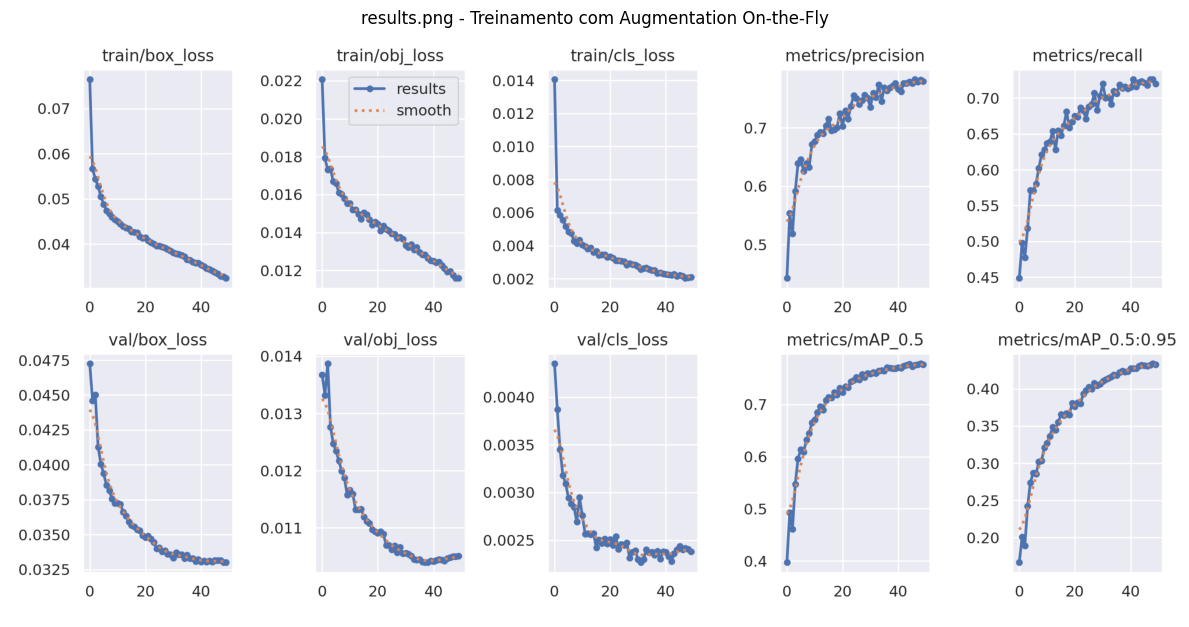

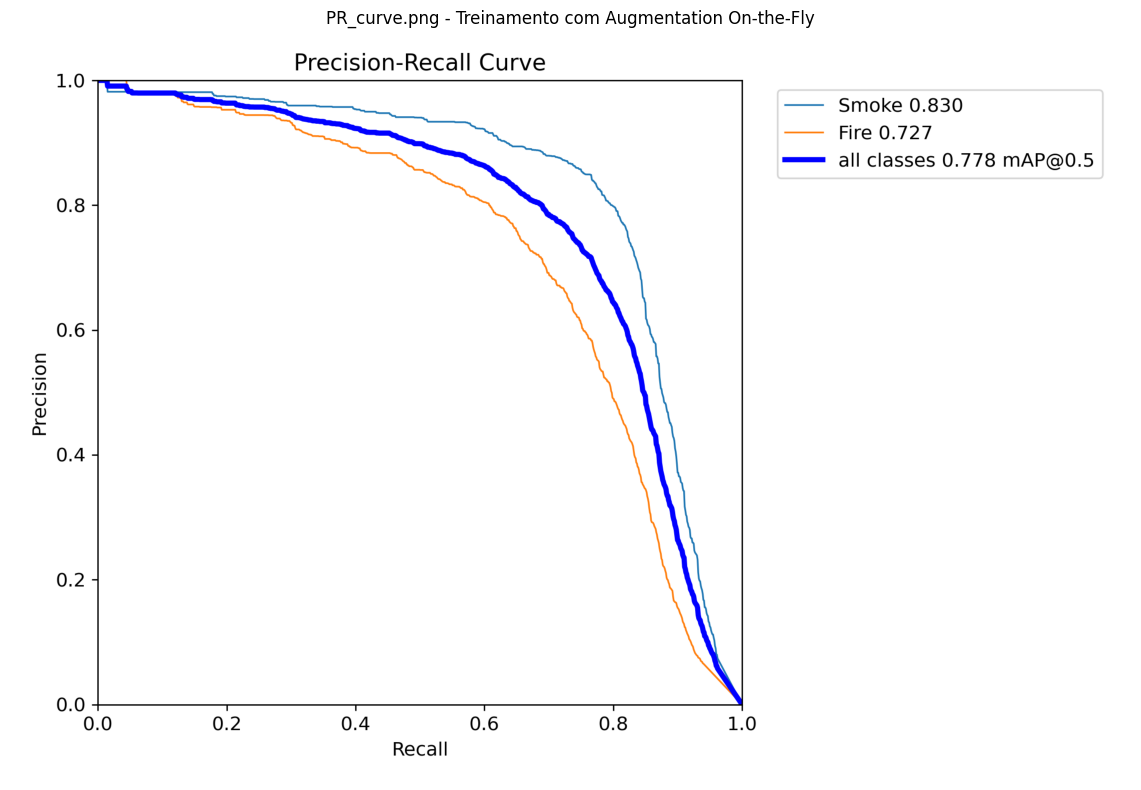

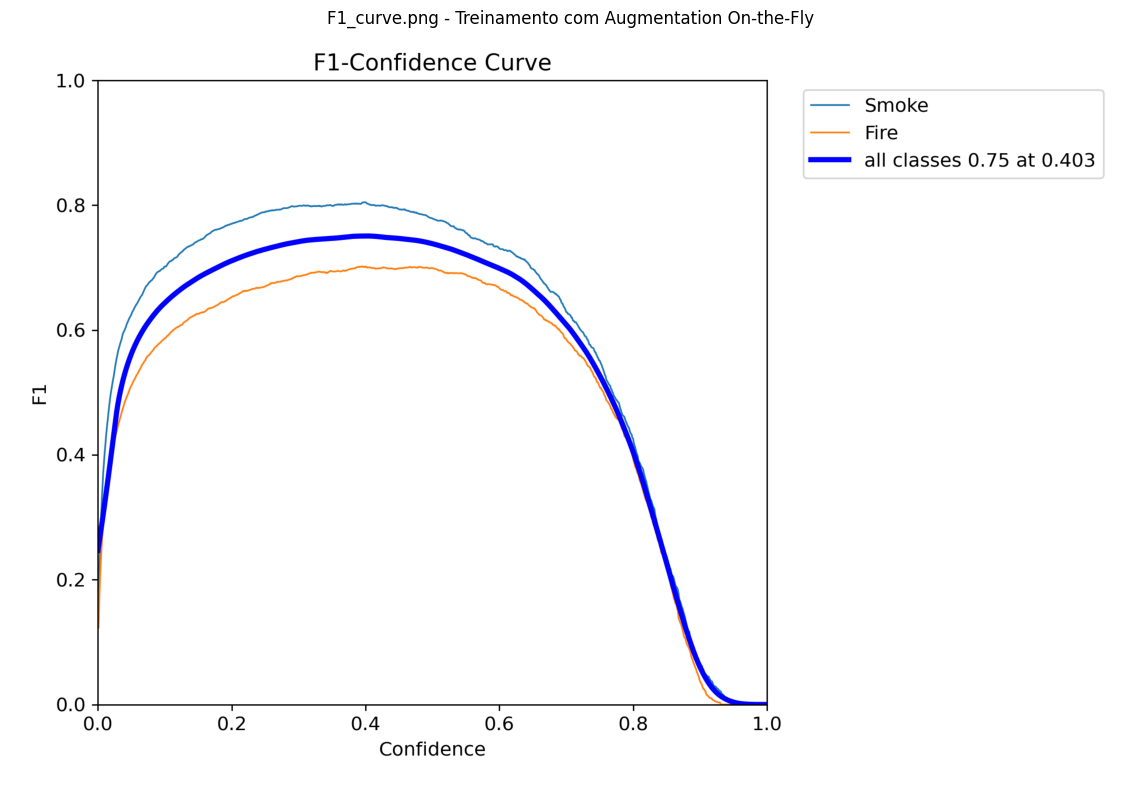

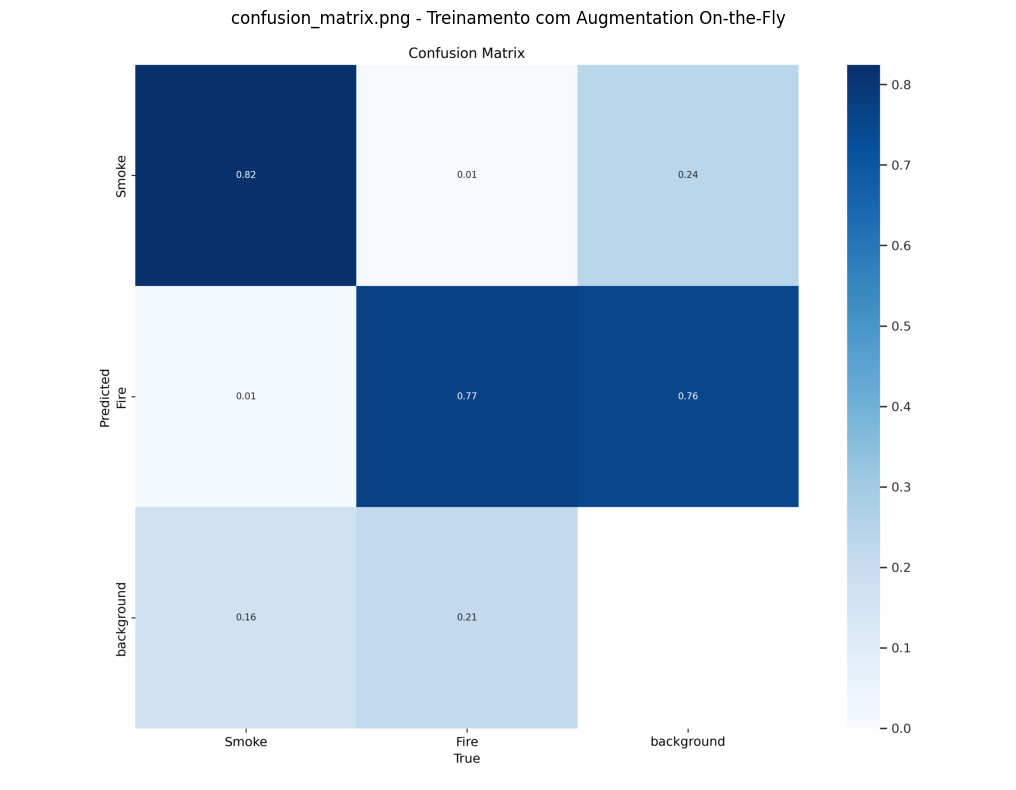

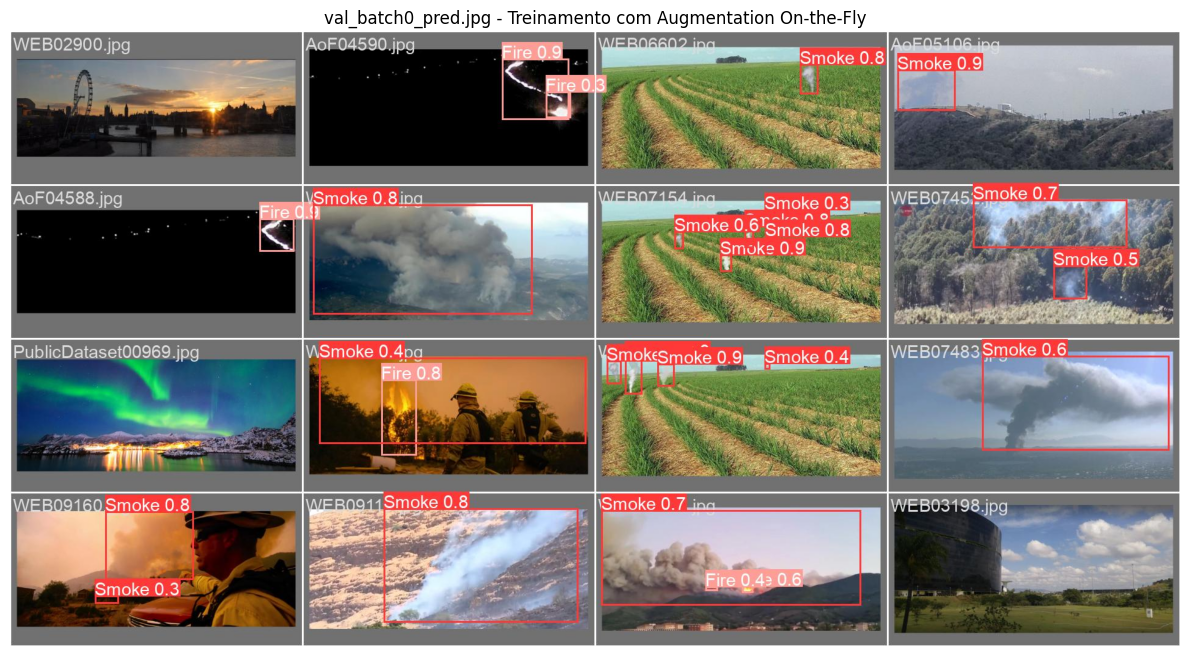

✅ OK


In [12]:
# ---------- ANÁLISE DE RESULTADOS ----------

results_csv = "/kaggle/working/yolov5/runs/train/onthefly_experiment/results.csv"

try:
    if os.path.exists(results_csv):
        df = pd.read_csv(results_csv)
        df.columns = df.columns.str.strip()

        last_epoch = df.iloc[-1]

        metrics = {
            "metrics/precision": "Precisão",
            "metrics/recall": "Recall", 
            "metrics/mAP_0.5": "mAP@0.5",
            "metrics/mAP_0.5:0.95": "mAP@0.5:0.95"
        }

        display(Markdown("### 📊 Métricas da Última Época (On-the-Fly)"))
        for key, label in metrics.items():
            if key in last_epoch:
                print(f"{label:>15}: {last_epoch[key]:.4f}")
            else:
                print(f"{label:>15}: (não encontrado)")
    else:
        print("Arquivo de resultados não encontrado")

except Exception as e:
    print(f"Erro ao ler resultados: {e}")

# ---------- VISUALIZAÇÕES ----------


exp_dir = "/kaggle/working/yolov5/runs/train/onthefly_experiment"

if os.path.exists(exp_dir):
    img_files = [
        "results.png",
        "PR_curve.png", 
        "F1_curve.png",
        "confusion_matrix.png",
        "val_batch0_pred.jpg"
    ]

    display(Markdown("## Visualizações do Treinamento (On-the-Fly)"))

    for file in img_files:
        path = os.path.join(exp_dir, file)
        if os.path.exists(path):
            try:
                img = plt.imread(path)
                plt.figure(figsize=(12, 8))
                plt.imshow(img)
                plt.title(f"{file} - Treinamento com Augmentation On-the-Fly")
                plt.axis('off')
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f" Erro ao carregar {file}: {e}")
        else:
            print(f" Arquivo não encontrado: {file}")
else:
    print(" Diretório de experimento não encontrado")

OK()